# Processo de difusão

treinar modelo com dados adicionando ruídos para prever a imagem original a partir de uma imagem com ruído, por exemplo

*density = true* faz com que o histograma retorno a densidade da probabilidade, pois força que a área do histograma seja igual a 1.

Quanto maior o **desvio padrão** (σ), mais variados os valores são da média

**Média** é o centro da distribuição, ponto com maior densidade

A distribuição é definida pela média e desvio padrão(chamado de variância, σ$^2$). 

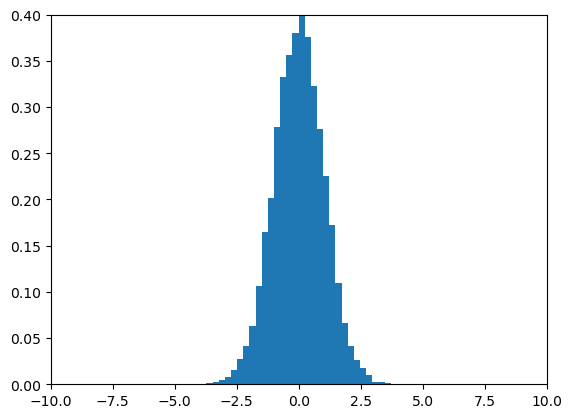

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_hist(values):
    plt.hist(values, bins=30, density=True)
    plt.xlim((-10,10))
    plt.ylim((0, 0.4))
    
values = torch.randn(10000)
plot_hist(values)

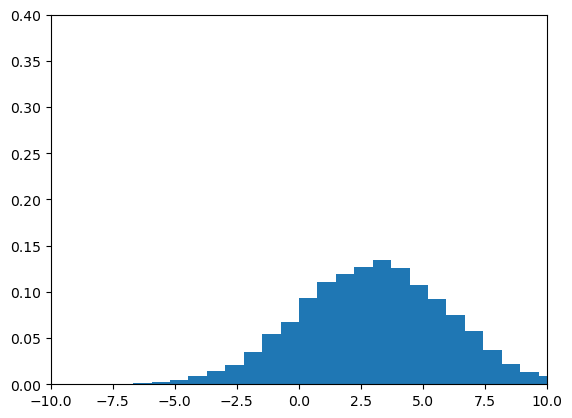

In [3]:
media = 3
var = 9
values2 = var**0.5*values + media
plot_hist(values2)

## Adição de ruído

Dado um valor x_0, é possível adicionar ruídos com um valor aleatório de acordo com a distribuição normal

In [5]:
def add_noise(x_0, mean=0, var=1):

    noise = var**0.5*torch.randn(1) + mean
    x_1 = x_0 + noise

    return x_1

x_0 = -5
print(add_noise(x_0))

tensor([-5.1840])


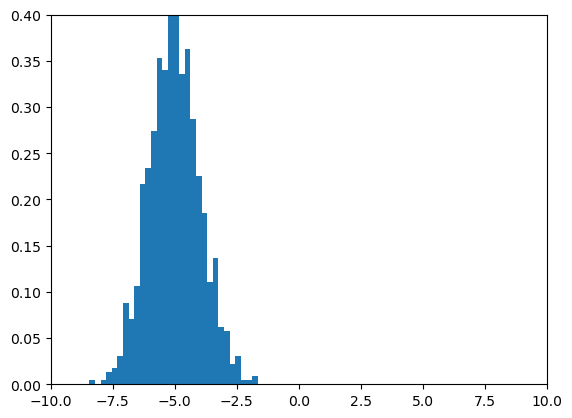

In [9]:
def add_noise_repeat(x_0, mean=0, var=1):
    
    n = 1000
    x_1s = []
    for _ in range(n):
        x_1 = add_noise(x_0, mean, var)
        x_1s.append(x_1.item())
    return x_1s


x_1s = add_noise_repeat(x_0)
plot_hist(x_1s)

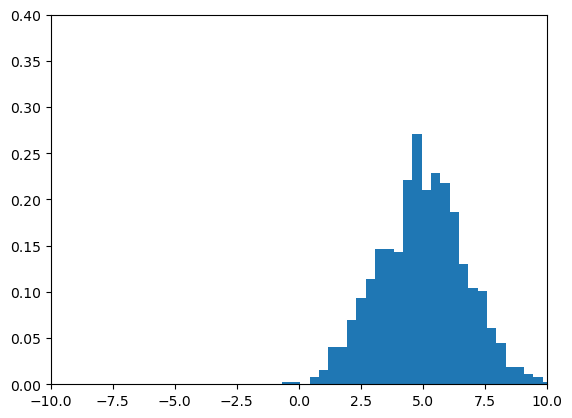

In [11]:
x_1s = add_noise_repeat(x_0, mean=10, var=3)
plot_hist(x_1s)

## Difusão:

Função que adiciona ruídos ao longo do tempo (passos)

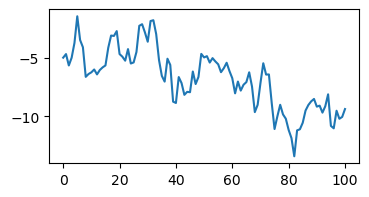

In [15]:
def diffuse(x_0, steps, mean=0, var=1):
    
    x = x_0
    x_ts = [x]
    
    for _ in range(steps):
        x = add_noise(x, mean, var)
        x_ts.append(x.item())
    
    return x_ts

x_ts = diffuse(x_0, 100)
plt.figure(figsize=(4,2))
plt.plot(x_ts)

Repetição de difusões: quanto mais passos, mais a distribuição vai sendo esticada

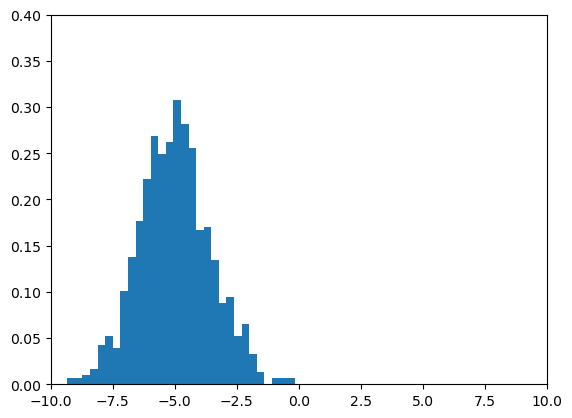

In [23]:
def diffuse_repeat(x_0, steps, mean=0, var=1):
    
    n = 1000
    x_finals = []
    
    for _ in range(n):
        # [-1] é para obter a posição final
        x_final = diffuse(x_0, steps, mean, var)[-1]
        x_finals.append(x_final)
    return x_finals

x_finals = diffuse_repeat(x_0, steps=2)
plot_hist(x_finals)

In [24]:
from IPython import display

def diffusion_evolution(x_0, max_steps, mean=0, var=1):
    x_finals_step = []
    for steps in range(max_steps):
        x_finals = diffuse_repeat(x_0, steps, mean, var)
        x_finals_step.append(x_finals)
    return x_finals_step

probs_per_step = diffusion_evolution(x_0, max_steps=20, mean=0.4)

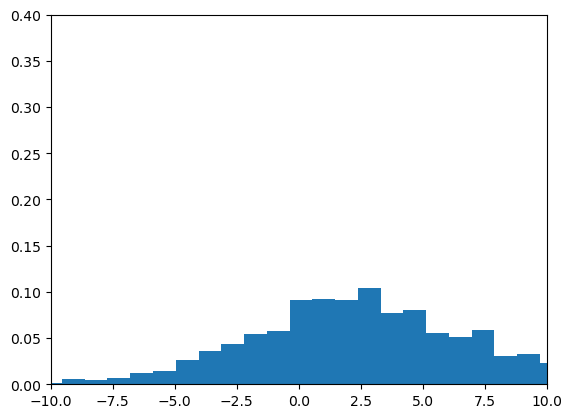

In [25]:
for x_finals in probs_per_step:
    plot_hist(x_finals)
    display.clear_output(wait=True)
    plt.show() 

## Adição de ruído em imagens

In [29]:
from PIL import Image

x_0 = Image.open('../data/basset_hound_53.jpg')
# Normaliza a imagem para o intervalo [-1, 1]
x_0 = torch.from_numpy(np.array(x_0))/255
x_0 = 2*x_0 -1

Pela adição de ruído, o objetivo é transformar uma distribuição qualquer em uma distribuição normal

Por isso, a partir de uma distribuição aleatória é possível voltar à distribuição original

### Caminho:

Parte de uma região da imagem real -> etapa -> etapa -> etapa ... -> região aleatória das imagens

A cada etapa, o nível do ruído é aumentado.


Assim, o treinamento do modelo é feito utilizando **uma imagem com ruído** para prever a **imagem com menos ruído** (entre várias etapas do caminho).

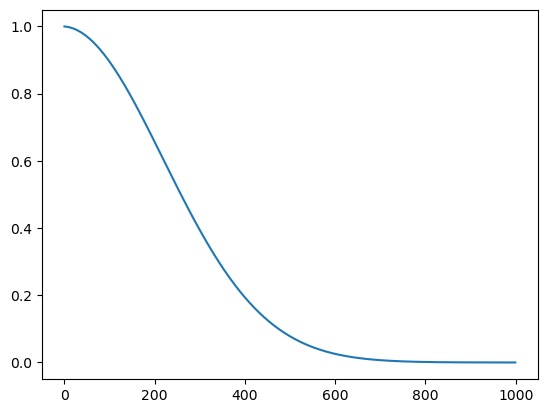

In [38]:
# Variância inicial do ruído
beta_start = 0.0001
# Variância final do ruído
beta_end = 0.02
# Número total de passos
n_steps = 1000
# Variância dos ruídos adicionados a cada passo
betas = torch.linspace(beta_start, beta_end, n_steps)
# Produto acumulado de 1-variância (representa o quanto da imagem foi 
# preservado após n passos)
alphas = (1-betas).cumprod(dim=0)
plt.plot(alphas)

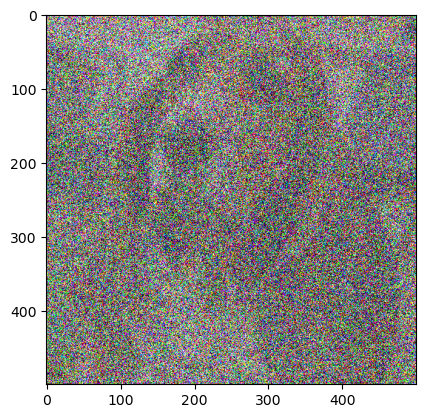

In [39]:
step = 500
alpha_t = alphas[step]
noise = torch.randn(x_0.shape)
z_t = alpha_t.sqrt()*x_0 + (1-alpha_t).sqrt()*noise 
z_t = (z_t+1)/2
z_t = z_t.clamp(0, 1)
plt.imshow(z_t)